# Machine Learning in Healthcare and Biomedicine - Coursework iPython Notebook

In [162]:
# importing modules used in this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_text


### INTRODUCTION: Data cleaning and description

In [117]:
columns = ['BI_RADS','age','shape','margin','density','severity']
data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data", 
names=columns)
print("5 columns of the uncleaned dataset:")
data.head()

5 columns of the uncleaned dataset:


,BI_RADS,age,shape,margin,density,severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [26]:
num_benign = data[data["severity"]==0].shape[0]
num_malign = data[data["severity"]==1].shape[0]

print("Number of benign tumours:", num_benign)
print("Number of malign tumours:", num_malign)

Number of benign tumours: 516
Number of malign tumours: 445


#### Dealing with missing values

In [118]:
# from the data preview above, we can see that the missing values are question marks
data_nan = data[data != '?'] # change the question marks to NaN

print("Number of missing instances for each feature:")
miss_count = pd.DataFrame(data_nan.isnull().sum(),columns=["Number of missing values"])
miss_count.index.name='Feature'
miss_count

Number of missing instances for each feature:


,Number of missing values
Feature,
BI_RADS,2
age,5
shape,31
margin,48
density,76
severity,0


In [119]:
# inspecting how the distribution of missing values varies by label

data_onlynan = data_nan[data_nan.isnull().any(1)]
df_temp = pd.DataFrame([data_onlynan[data_onlynan['severity']==0].isnull().sum()*100/num_benign,
    data_onlynan[data_onlynan['severity']==1].isnull().sum()*100/num_malign],
    index=['% NaN in Benign','% NaN in Malign'])

display(df_temp)
print("Conclusion: doesn't look like NaN frequency depends on label")


,BI_RADS,age,shape,margin,density,severity
% NaN in Benign,0.193798,0.000000,3.682171,7.170543,10.465116,0.0
% NaN in Malign,0.224719,1.123596,2.696629,2.471910,4.943820,0.0


Conclusion: doesn't look like NaN frequency depends on label


In [126]:
# removing rows with missing values
data_nomiss = data_nan.dropna()
print("overall data shape after removing missing values: {} rows, {} columns".format(data_nomiss.shape[0],data_nomiss.shape[1])) # 830 instances left
print("Number of benign tumours after NaN removal:", data_nomiss[data_nomiss["severity"]==0].shape[0])
print("Number of malign tumours after NaN removal:", data_nomiss[data_nomiss["severity"]==1].shape[0])

df = data_nomiss.copy() # reassigning to a new variable
df = df.astype(int) # changing object types to integer types

overall data shape after removing missing values: 830 rows, 6 columns
Number of benign tumours after NaN removal: 427
Number of malign tumours after NaN removal: 403


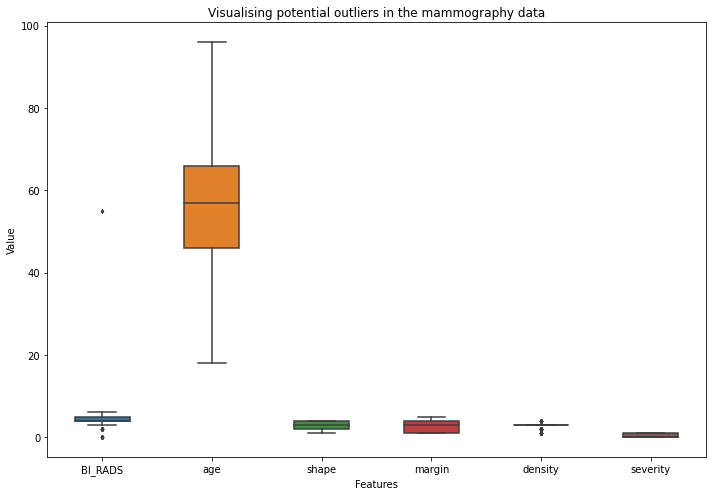

Can see some sort of outlier in the BI_RADS feature


In [86]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(data=df, width= 0.5,ax=ax,  fliersize=3)
plt.title("Visualising potential outliers in the mammography data")
plt.xlabel("Features")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

print("Can see some sort of outlier in the BI_RADS feature")

In [127]:
print("Closer look at the BI-RADS outlier:")
print("Distinct values of BI-RADS feature below. We know that BI-RADS should only go between 0 and 6")
display(pd.DataFrame(df['BI_RADS'].value_counts().rename("Frequency")))
print("We can assume that the 55 is supposed to be a 5")
# changing the 55 to a 5
df["BI_RADS"][df["BI_RADS"] == 55] = 5

Closer look at the BI-RADS outlier:
Distinct values of BI-RADS feature below. We know that BI-RADS should only go between 0 and 6


,Frequency
4,468
5,316
3,24
6,9
2,7
0,5
55,1


We can assume that the 55 is supposed to be a 5


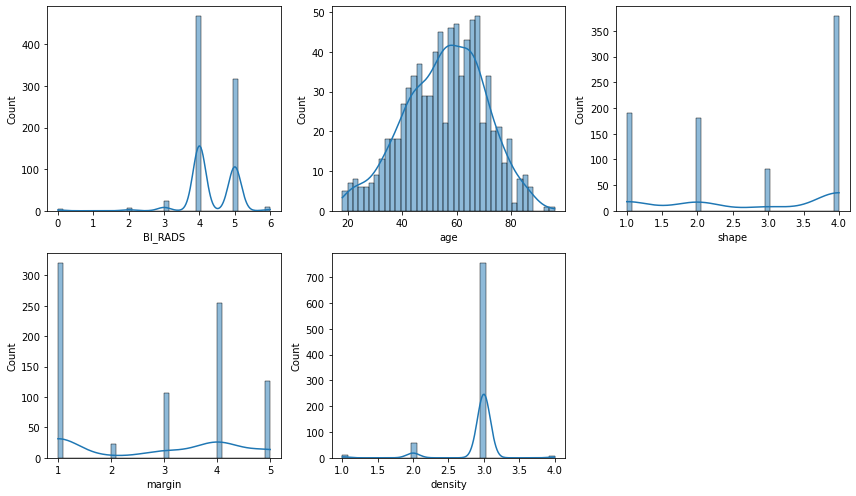

In [88]:
fig, axes_noout = plt.subplots(2,3,figsize=(12,7))
sns.histplot(x='BI_RADS',kde=True, data =df, ax=axes_noout[0,0], bins=40)
sns.histplot(x='age',kde=True, data =df, ax=axes_noout[0,1], bins=40)
sns.histplot(x='shape',kde=True, data =df, ax=axes_noout[0,2], bins=40)
sns.histplot(x='margin',kde=True, data =df, ax=axes_noout[1,0], bins=40)
sns.histplot(x='density',kde=True, data =df, ax=axes_noout[1,1], bins=40)

fig.delaxes(axes_noout[1,2])
plt.tight_layout()

#### Data description and feature selection

In [89]:
print("Below: Data desciption of the cleaned data set. Note that age is the only continuous feature so the other feature descriptions can be discarded.")
display(df.describe().T)

Below: Data desciption of the cleaned data set. Note that age is the only continuous feature so the other feature descriptions can be discarded.


,count,mean,std,min,25%,50%,75%,max
BI_RADS,830.0,4.333735,0.688134,0.0,4.0,4.0,5.0,6.0
age,830.0,55.781928,14.671782,18.0,46.0,57.0,66.0,96.0
shape,830.0,2.781928,1.242361,1.0,2.0,3.0,4.0,4.0
margin,830.0,2.813253,1.567175,1.0,1.0,3.0,4.0,5.0
density,830.0,2.915663,0.350936,1.0,3.0,3.0,3.0,4.0
severity,830.0,0.485542,0.500092,0.0,0.0,0.0,1.0,1.0


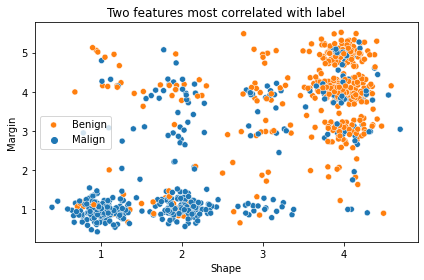

In [90]:
# Visualising the boundary space


def jitter(values,i,j): # applying some random noise to the integer points for visualisation
    return values + np.random.normal(i,j,values.shape)


sns.scatterplot(x = jitter(df["shape"],0,0.2),
    y = jitter(df["margin"],0,0.2),
    hue=df['severity'])
plt.xlabel("Shape")
plt.ylabel("Margin")
plt.title("Two features most correlated with label")
plt.legend(['Benign','Malign'])
plt.tight_layout()
plt.show()



In [128]:
# encoding the nominal data into one-hot encoding: shape and margin
df_encoding = df.copy(deep=True)
df_encoding = pd.get_dummies(df_encoding,columns=["shape","margin"])
df_encoding.head()

,BI_RADS,age,density,severity,shape_1,shape_2,shape_3,shape_4,margin_1,margin_2,margin_3,margin_4,margin_5
0,5,67,3,1,0,0,1,0,0,0,0,0,1
2,5,58,3,1,0,0,0,1,0,0,0,0,1
3,4,28,3,0,1,0,0,0,1,0,0,0,0
8,5,57,3,1,1,0,0,0,0,0,0,0,1
10,5,76,3,1,1,0,0,0,0,0,0,1,0


# Feature Selection
1. is the data balanced? - yes I would say it's sufficiently balanced
2. how to deal with the categorical data? For decision trees, don't need to change it, one-hot encoding for the rest
3. correlation matrix - get rid of BIRADS bc it's data leakage

In [92]:
# how balanced is the data?
clean_num_benign = df[df["severity"]==0].shape[0]
clean_num_malign = df[df["severity"]==1].shape[0]

print("Number of benign tumours:", clean_num_benign)
print("Number of malign tumours:", clean_num_malign)
print("I would say that this is a sufficiently balanced dataset - no need for up/downsampling")

Number of benign tumours: 427
Number of malign tumours: 403
I would say that this is a sufficiently balanced dataset - no need for up/downsampling


In [129]:
# BI_RADS is not supposed to be a predictive so let's get rid of the BI-RADS feature
df = df.drop(columns="BI_RADS")
df_encoding = df_encoding.drop(columns="BI_RADS")

Density has a very low correlation with the label feature, severity, so we can remove it from our dataset


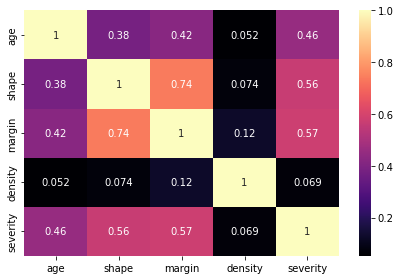

In [130]:
# correlation matrix
sns.heatmap(df.corr(),annot=True,cmap="magma")
plt.tight_layout()
print("Density has a very low correlation with the label feature, severity, so we can remove it from our dataset")

df.drop(columns="density",inplace=True)
df_encoding.drop(columns="density",inplace=True)

In [131]:
# we should normalise the age because it has a much larger range than the other variables and might cause a bias
# we saw that age has a roughly bell curve distribution so I think this is ok

scaler = MinMaxScaler() 
df_norm = df.copy(deep=True)
df_norm[['age']] = scaler.fit_transform(df_norm[['age']]) # normalised and not encoded

df_norm_encoding = df_encoding.copy()
df_norm_encoding[['age']] = scaler.fit_transform(df_norm_encoding[['age']]) # normalised and encoded


# SVM
Using one-hot encoded categorical variables, without density

In [229]:
df_svm = df_norm_encoding.copy(deep=True)

# defining the train and test sets
X_svm = df_svm.loc[:,df_svm.columns != 'severity'].values
y_svm = df_svm.loc[:,df_svm.columns == 'severity'].values
X_train_svm, X_test_svm, y_train_svm, y_test_svm  = train_test_split(X_svm,y_svm,test_size=0.3,random_state=42)

# hyperparameter tuning using gridsearch
param_grid = {'C': [0.1, 1, 10, 50, 100],
              'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}

svm_grid = GridSearchCV(SVC(random_state=42), param_grid, verbose = False)
svm_grid.fit(X_train_svm, y_train_svm.ravel())
 
print("Best training score:",svm_grid.best_score_)
print("Best parameters:",svm_grid.best_params_)
print("Best estimator:",svm_grid.best_estimator_)


Best training score: 0.8072502210433244
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best estimator: SVC(C=10, gamma=1, random_state=42)


In [232]:
svm_best = svm_grid.best_estimator_
svm_best.fit(X_train_svm, y_train_svm.ravel())
print('Test accuracy: %.3f' % svm_best.score(X_test_svm, y_test_svm.ravel()))

svm_predictions = svm_best.predict(X_test_svm)

# print(classification_report(y_test_svm, svm_predictions))
# print(confusion_matrix(y_test_svm,svm_predictions))

confmat_svm = confusion_matrix(y_test_svm,svm_predictions)
tp_svm = confmat_svm[0][0]
tn_svm = confmat_svm[1][1]
fp_svm = confmat_svm[0][1]
fn_svm = confmat_svm[1][0]

accuracy_svm = (tp_svm + tn_svm)/(tp_svm+tn_svm+fp_svm+fn_svm)
precision_svm = tp_svm/(tp_svm+fp_svm)
recall_svm = tp_svm/(tp_svm+fn_svm)
f1_svm = 2*(1/((1/precision_svm)+(1/recall_svm)))


Test accuracy: 0.807


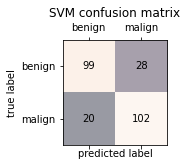

In [228]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_svm, cmap='rocket', alpha=0.4)
for i in range(confmat_svm.shape[0]):
    for j in range(confmat_svm.shape[1]):
        ax.text(x=j, y=i, s=confmat_svm[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.xticks(ticks=[0,1],labels=["benign","malign"])
plt.yticks(ticks=[0,1],labels=["benign","malign"])
plt.ylabel('true label')
plt.title("SVM confusion matrix")
plt.tight_layout()
plt.show()

# Decision tree
Could change the numerical encodings in the data back to words for more interpretability of the tree

In [230]:
df_dt = df_encoding.copy()
# usually you can put categorical variables into decision tree algorithms no problem but sklearn doesn't support this, only numerical values

# defining the train and test sets
X_dt = df_dt.loc[:,df_dt.columns != 'severity'].values
y_dt = df_dt.loc[:,df_dt.columns == 'severity'].values
X_train_dt, X_test_dt, y_train_dt, y_test_dt  = train_test_split(X_dt,y_dt,test_size=0.3,random_state=42)

# hyperparameter tuning
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, verbose = False)
dt_grid.fit(X_train_dt, y_train_dt.ravel())

print("Best training score:",dt_grid.best_score_)
print("Best parameters:",dt_grid.best_params_)
print("Best estimator:",dt_grid.best_estimator_)


Best training score: 0.7882994400235781
Best parameters: {'criterion': 'entropy', 'max_depth': 3}
Best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)


Test accuracy: 0.783


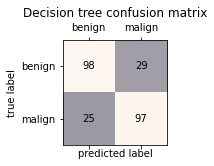

In [224]:
dt_best = dt_grid.best_estimator_
dt_best.fit(X_train_dt, y_train_dt.ravel())
print('Test accuracy: %.3f' % dt_best.score(X_test_dt, y_test_dt.ravel()))

dt_predictions = dt_best.predict(X_test_dt)

confmat_dt = confusion_matrix(y_test_dt,dt_predictions)
tp_dt = confmat_dt[0][0]
tn_dt = confmat_dt[1][1]
fp_dt = confmat_dt[0][1]
fn_dt = confmat_dt[1][0]

accuracy_dt = (tp_dt + tn_dt)/(tp_dt+tn_dt+fp_dt+fn_dt)
precision_dt = tp_dt/(tp_dt+fp_dt)
recall_dt = tp_dt/(tp_dt+fn_dt)
f1_dt = 2*(1/((1/precision_dt)+(1/recall_dt)))

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_dt, cmap='rocket', alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat_dt[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.xticks(ticks=[0,1],labels=["benign","malign"])
plt.yticks(ticks=[0,1],labels=["benign","malign"])
plt.ylabel('true label')
plt.title("Decision tree confusion matrix")
plt.tight_layout()
plt.show()

# print(classification_report(y_test_dt, dt_predictions))
# print(confusion_matrix(y_test_dt,dt_predictions))

In [222]:
results_df = pd.DataFrame([[100*accuracy_dt,100*precision_dt,100*recall_dt,f1_dt],[100*accuracy_svm,100*precision_svm,100*recall_svm,f1_svm]],
    columns=['Accuracy (%)','Precision (%)','Recall (%)','F1'],index=['Decision Tree','SVM']).round(decimals=2)

display(results_df)



,Accuracy (%),Precision (%),Recall (%),F1
Decision Tree,78.31,77.17,79.67,0.78
SVM,80.72,77.95,83.19,0.80


if condition is satisfied, you go to the left child node


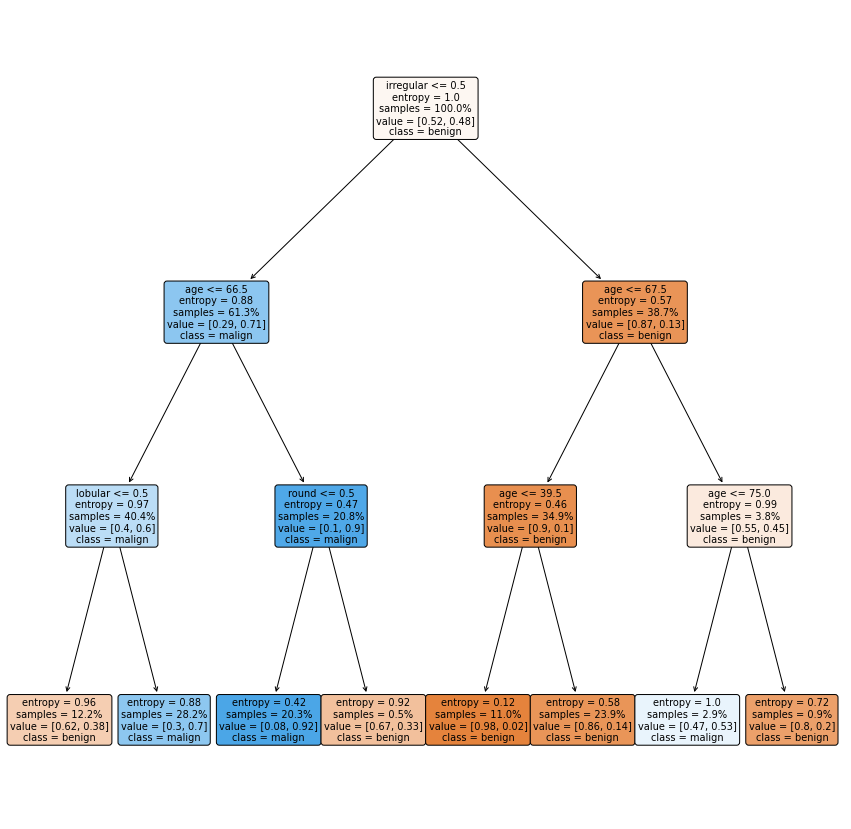

In [185]:
features = ['age','density','round', 'oval', 'lobular','irregular',
'circumscribed','microlobulated','ill-defined','spiculated','high','iso',
'low','fat-containing']
classes = ['benign','malign']

print("if condition is satisfied, you go to the left child node")
fig, tree_ax = plt.subplots(figsize=(15,15))
tree.plot_tree(dt_best,ax=tree_ax,feature_names=features,class_names=classes,filled=True,rounded=True,proportion=True,precision=2)
plt.show()

<AxesSubplot:>

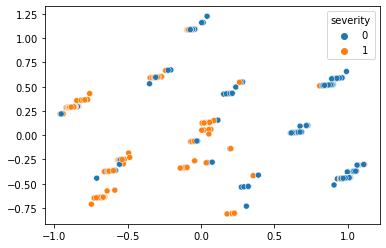

In [44]:
train, test = train_test_split(df_norm_encoding, test_size=2)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train.loc[:,train.columns != 'severity'])
sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],hue=train['severity'])

